In [4]:
from imports import *

In [5]:
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
import time

In [6]:
scoring = {'AUC': 'roc_auc',
           'Precision': make_scorer(precision_score, pos_label=1), 
           'Recall': make_scorer(recall_score, pos_label=-1),
           'F1': make_scorer(f1_score, average='weighted')}

In [7]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=True, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
print(f"SF anomaly rate is {anomaly_rate_sf:.1%} / {len(dfsf)}")

dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

SF anomaly rate is 4.5% / 73237


In [79]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=1)
gs_svm_1 = GridSearchCV(OneClassSVM(random_state = 1, n_jobs = -1),
                       param_grid={'contamination': np.arange(0.005, 0.02, 0.001), 'n_estimators': [100], 'max_samples': [0.25]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_1.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_svm_1 = gs_svm_1.cv_results_

Time for SVM fitting: 586.013


In [81]:
gs_sf_1 = GridSearchCV(OneClassSVM(),
                  param_grid={'nu': np.arange(0.045, 0.055, 0.001), 'kernel': ['poly'], 'gamma': ['auto'], 'degree': [2]},
                  scoring=scoring, refit='Recall')
stime = time.time()
gs_sf_1.fit(x_sf, y_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_svm_sf_1 = gs_sf_1.cv_results_

Time for IF fitting: 356.985


In [70]:
best_index = np.nonzero(results_svm_sf_1['rank_test_F1_n'] == 1)[0][0]
best_score_1 = results_svm_sf_1['mean_test_F1_n'][best_index]
best_param_1 = results_svm_sf_1['params'][best_index]
print(f"{best_index}: {best_param_1} : {best_score_1}")

stime = time.time()
y_pred_1 = OneClassSVM(kernel="rbf", gamma='scale', nu=0.055).fit(X_train_sf).predict(X_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
f1 = fbeta_score(y_test_sf, y_pred_1, labels=[-1], average='macro', beta=0.5) 
print(classification_report(y_test_sf, y_pred_1, target_names=['anomaly', 'normal']))


stime = time.time()
y_pred_not_tuned = OneClassSVM(kernel="rbf", gamma='scale', nu=0.045).fit(X_train_sf).predict(X_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
f1_not_tuned_1 = fbeta_score(y_test_sf, y_pred_not_tuned, labels=[-1], average='macro', beta=0.5) 
print(classification_report(y_test_sf, y_pred_not_tuned, target_names=['anomaly', 'normal']))

3: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.048}
Time for SVM fitting: 9.053
              precision    recall  f1-score   support

     anomaly       0.06      0.07      0.06       836
      normal       0.96      0.95      0.95     17474

    accuracy                           0.91     18310
   macro avg       0.51      0.51      0.51     18310
weighted avg       0.91      0.91      0.91     18310

Time for SVM fitting: 7.353
              precision    recall  f1-score   support

     anomaly       0.46      0.71      0.56       836
      normal       0.99      0.96      0.97     17474

    accuracy                           0.95     18310
   macro avg       0.72      0.84      0.76     18310
weighted avg       0.96      0.95      0.95     18310



In [38]:
stime = time.time()
y_pred_not_tuned = OneClassSVM(kernel="rbf", gamma='scale', nu=0.045).fit(X_train_sf).predict(X_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
f1_not_tuned_1 = fbeta_score(y_test_sf, y_pred_not_tuned, labels=[-1], average='macro', beta=0.5) 
f1_not_tuned_1

Time for SVM fitting: 5.747


0.5002581977794992

In [16]:
gs_sf_2 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='auto'),
                  param_grid={'nu': np.arange(0.04, 0.24, 0.04)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sf_2.fit(X_train_sf, y_train_sf)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sf_2 = gs_sf_2.cv_results_

stime = time.time()
y_pred = gs_sf_2.predict(X_test_sf)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 238.868
Time for OCSVM prediction: 0.596


In [21]:
stime = time.time()
y_pred_not_tuned = OneClassSVM(kernel="rbf", gamma='auto', nu=0.045).fit(X_train_sf).predict(X_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
f1_not_tuned_2 = fbeta_score(y_test_sf, y_pred_not_tuned, labels=[-1], average='macro', beta=0.5) 

Time for SVM fitting: 5.811


In [17]:
gs_sf_3 = GridSearchCV(OneClassSVM(kernel="linear", gamma='auto'),
                  param_grid={'nu': np.arange(0.04, 0.24, 0.04)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sf_3.fit(X_train_sf, y_train_sf)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sf_3 = gs_sf_3.cv_results_

stime = time.time()
y_pred = gs_sf_3.predict(X_test_sf)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 121.492
Time for OCSVM prediction: 0.312


In [22]:
stime = time.time()
y_pred_not_tuned = OneClassSVM(kernel="linear", gamma='auto', nu=0.045).fit(X_train_sf).predict(X_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
f1_not_tuned_3 = fbeta_score(y_test_sf, y_pred_not_tuned, labels=[-1], average='macro', beta=0.5) 

Time for SVM fitting: 2.824


In [18]:
gs_sf_4 = GridSearchCV(OneClassSVM(kernel="linear", gamma='scale'),
                  param_grid={'nu': np.arange(0.04, 0.24, 0.04)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sf_4.fit(X_train_sf, y_train_sf)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sf_4 = gs_sf_4.cv_results_

stime = time.time()
y_pred = gs_sf_4.predict(X_test_sf)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 121.980
Time for OCSVM prediction: 0.317


In [23]:
stime = time.time()
y_pred_not_tuned = OneClassSVM(kernel="linear", gamma='scale', nu=0.045).fit(X_train_sf).predict(X_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
f1_not_tuned_4 = fbeta_score(y_test_sf, y_pred_not_tuned, labels=[-1], average='macro', beta=0.5) 

Time for SVM fitting: 2.768


<ipython-input-28-c0941da69862>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


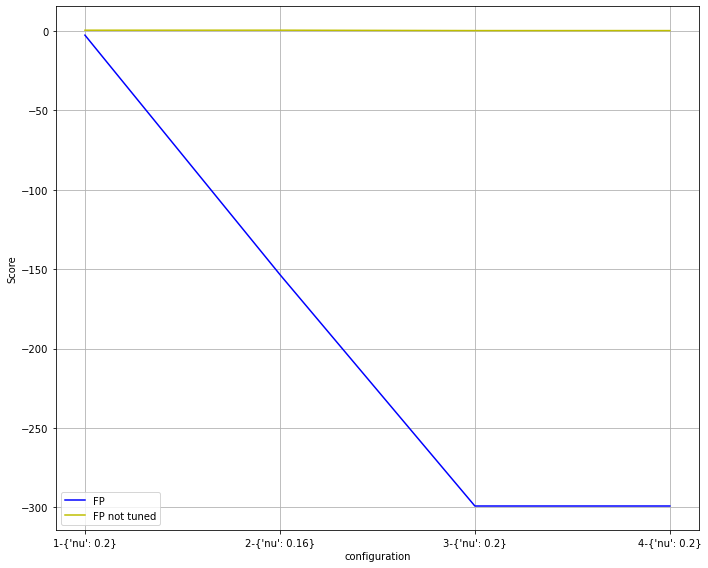

In [28]:
# X_axis = np.array(results_svm["param_nu"].data, dtype=float)
# print GridSearch cross-validation for parameters
# X_axis_if = np.array(results_if["param_contamination"].data, dtype=float)
plt.figure(figsize=(10,8))

plt.xlabel("configuration")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
pad = 0.005

colors = {'lof': 'r', 'if':'b', 'dbscan':'c', 'svm':'y'}
scorer = 'FP'

best_index = np.nonzero(results_svm_sf_1['rank_test_%s' % scorer] == 1)[0][0]
best_score_1 = results_svm_sf_1['mean_test_%s' % scorer][best_index]
best_param_1 = results_svm_sf_1['params'][best_index]

best_index = np.nonzero(results_svm_sf_2['rank_test_%s' % scorer] == 1)[0][0]
best_score_2 = results_svm_sf_2['mean_test_%s' % scorer][best_index]
best_param_2 = results_svm_sf_2['params'][best_index]

best_index = np.nonzero(results_svm_sf_3['rank_test_%s' % scorer] == 1)[0][0]
best_score_3 = results_svm_sf_3['mean_test_%s' % scorer][best_index]
best_param_3 = results_svm_sf_3['params'][best_index]

best_index = np.nonzero(results_svm_sf_4['rank_test_%s' % scorer] == 1)[0][0]
best_score_4 = results_svm_sf_4['mean_test_%s' % scorer][best_index]
best_param_4 = results_svm_sf_4['params'][best_index]

Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
Y_axis_not_tuned = np.array([f1_not_tuned_1, f1_not_tuned_2, f1_not_tuned_3, f1_not_tuned_4])
X_axis = np.array([f"1-{best_param_1}", f"2-{best_param_2}", f"3-{best_param_3}", f"4-{best_param_4}"])

ax.plot(X_axis, Y_axis, '-', color=colors['if'],label="%s " % (scorer))
ax.plot(X_axis, Y_axis_not_tuned, '-', color=colors['svm'],label="%s not tuned" % (scorer))
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("svm_nu.png", dpi=100)

plt.show()

In [55]:
sa = datasets.fetch_kddcup99(subset='SA', percent10=True, random_state=0)
dfsa = pd.DataFrame(sa.data, columns=sa_columns)
dfsa["target"]=sa.target
anomaly_rate =  1.0 - len(dfsa.loc[dfsa["target"]==b'normal.'])/len(dfsa)
print(f"SA anomaly rate is {anomaly_rate:.1%}")

dfsa['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsa["target"]]
toDecodeSA = ["protocol_type", "service", "flag", "target"]
le = preprocessing.LabelEncoder()
for f in toDecodeSA:
    dfsa[f] = list(map(byte_decoder, dfsa[f]))
    dfsa[f] = le.fit_transform(dfsa[f])

X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(dfsa.drop(["target", 'binary_target'], axis=1), dfsa['binary_target'], test_size=0.25, random_state=0)

SA anomaly rate is 3.4%


In [65]:
r = 0.01
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=0.1, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 1.0% out of 98261 records (983)


In [66]:
r = 0.02
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=0.2, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 2.0% out of 198527 records (3971)


In [59]:
scoring = {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score, pos_label=-1), 'F1': make_scorer(fbeta_score, labels=[-1], average='macro', beta=0.5)}
gs = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs.fit(X_train_sf, y_train_sf)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm = gs.cv_results_

stime = time.time()
y_pred = gs.predict(X_test_sf)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 260.066
Time for OCSVM prediction: 0.194


In [60]:
gs_sa = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa.fit(X_train_sa, y_train_sa)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa = gs.cv_results_

stime = time.time()
y_pred = gs_sa.predict(X_test_sa)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 2996.328
Time for OCSVM prediction: 5.784


In [ ]:
gs_sa_poly = GridSearchCV(OneClassSVM(kernel="poly"),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05),
                             'gamma': ['scale', 'auto'],
                             'degree': np.array([2,3,4])},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_poly.fit(X_train_sa, y_train_sa)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa_poly = gs_sa_poly.cv_results_

stime = time.time()
y_pred = gs_sa_poly.predict(X_test_sa)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

In [ ]:
gs_sa_poly = GridSearchCV(OneClassSVM(kernel="sigmoid", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_poly.fit(X_train_sa, y_train_sa)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa_poly = gs_sa_poly.cv_results_

stime = time.time()
y_pred = gs_sa_poly.predict(X_test_sa)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

In [68]:
gs_sa_1 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_1.fit(x_train_1, y_train_1)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa_1 = gs_sa_1.cv_results_

stime = time.time()
y_pred = gs_sa_1.predict(x_test_1)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 2107.779
Time for OCSVM prediction: 1.039


In [69]:
gs_sa_2 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_2.fit(x_train_2, y_train_2)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa = gs_sa_2.cv_results_

stime = time.time()
y_pred = gs_sa_2.predict(x_test_2)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 12059.687
Time for OCSVM prediction: 25.436


In [80]:
fit_time = [260.066, 2996.328, 2107.779, 12059.687]

<ipython-input-81-68d2061ab5f3>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


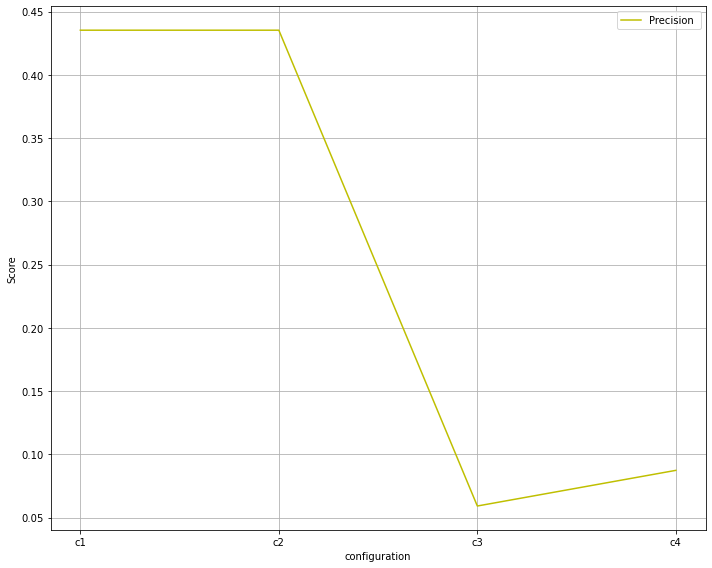

In [81]:
# X_axis = np.array(results_svm["param_nu"].data, dtype=float)
# print GridSearch cross-validation for parameters
X_axis_if = np.array(results_if["param_contamination"].data, dtype=float)
plt.figure(figsize=(10,8))

plt.xlabel("configuration")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
pad = 0.005

colors = {'lof': 'r', 'if':'b', 'dbscan':'c', 'svm':'y'}
scorer = 'Precision'

best_index = np.nonzero(results_svm['rank_test_%s' % scorer] == 1)[0][0]
best_score_svm = results_svm['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa['rank_test_%s' % scorer] == 1)[0][0]
best_score_sa = results_svm_sa['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa_1['rank_test_%s' % scorer] == 1)[0][0]
best_score_1 = results_svm_sa_1['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa_2['rank_test_%s' % scorer] == 1)[0][0]
best_score_2 = results_svm_sa_2['mean_test_%s' % scorer][best_index]

Y_axis = np.array([best_score_svm, best_score_sa, best_score_1, best_score_2])
X_axis = np.array(['c1', 'c2', 'c3', 'c4'])

ax.plot(X_axis, Y_axis, '-', color=colors['svm'],label="%s " % (scorer))
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("nu.png", dpi=100)

plt.show()

# for scorer, color in zip(sorted(scoring), ['b', 'k']):
#     sample, style= ('test', '-')
#     sample_score_mean = results_svm['mean_%s_%s' % (sample, scorer)]
# #    sample_score_std = results_svm['std_%s_%s' % (sample, scorer)]
    
#     sample_score_mean_lof = results_lof['mean_%s_%s' % (sample, scorer)]
# #    sample_score_std_lof = results_lof['std_%s_%s' % (sample, scorer)]
    
# #     We don't plot standard deviation    
# #     ax.fill_between(X_axis, sample_score_mean - sample_score_std,
# #                 sample_score_mean + sample_score_std,
# #                 alpha=0.1 if sample == 'test' else 0, color=color)
#     ax.plot(X_axis, sample_score_mean, style, color=color,
#         alpha=1 if sample == 'test' else 0.7,
#         label="%s (%s)" % (scorer, sample))

#     best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
#     best_score = results['mean_test_%s' % scorer][best_index]

#     # Plot a dotted vertical line at the best score for that scorer marked by x
#     ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#         linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

#     # Annotate the best score for that scorer
#     ax.annotate("%0.2f" % best_score,
#             (X_axis[best_index], best_score+pad))
    
# plt.legend(loc="best")
# plt.grid('off')
# plt.tight_layout()
# plt.savefig("nu.png", dpi=100)

# plt.show()

# Archive

In [63]:
results_svm

{'mean_fit_time': array([ 0.61091375,  5.07705498,  9.18493633, 13.29303331, 16.88273849]),
 'std_fit_time': array([0.01198042, 0.12844537, 0.08549168, 0.08558367, 0.30675319]),
 'mean_score_time': array([0.1449966 , 0.74371862, 1.3358501 , 1.94709306, 2.59730806]),
 'std_score_time': array([0.00463848, 0.01713212, 0.01801429, 0.02144899, 0.06321599]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.94115565, 0.91135687, 0.91014531, 0.89717969, 0.93749916]),
 'split1_test_AUC': array([0.95307346, 0.92250814, 0.91347697, 0.8959531 , 0.93966566]),
 'split2_test_AUC': array([0.95114229, 0.92344162, 0.9168717 , 0.9012755 , 0.93832205]),
 'sp

In [70]:
results_svm_sa = gs.cv_results_
results_svm_sa

{'mean_fit_time': array([ 0.61091375,  5.07705498,  9.18493633, 13.29303331, 16.88273849]),
 'std_fit_time': array([0.01198042, 0.12844537, 0.08549168, 0.08558367, 0.30675319]),
 'mean_score_time': array([0.1449966 , 0.74371862, 1.3358501 , 1.94709306, 2.59730806]),
 'std_score_time': array([0.00463848, 0.01713212, 0.01801429, 0.02144899, 0.06321599]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.94115565, 0.91135687, 0.91014531, 0.89717969, 0.93749916]),
 'split1_test_AUC': array([0.95307346, 0.92250814, 0.91347697, 0.8959531 , 0.93966566]),
 'split2_test_AUC': array([0.95114229, 0.92344162, 0.9168717 , 0.9012755 , 0.93832205]),
 'sp

In [53]:
results_if

{'mean_fit_time': array([2.36972971, 2.23002892, 2.23278694, 2.26178975, 2.20120721]),
 'std_fit_time': array([0.35499806, 0.04266414, 0.04018767, 0.06024252, 0.02619915]),
 'mean_score_time': array([1.02248826, 1.01561413, 1.01032758, 1.01449027, 0.98523035]),
 'std_score_time': array([0.03878348, 0.03293335, 0.03019608, 0.08170886, 0.02489543]),
 'param_contamination': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'contamination': 0.01},
  {'contamination': 0.060000000000000005},
  {'contamination': 0.11},
  {'contamination': 0.16000000000000003},
  {'contamination': 0.21000000000000002}],
 'split0_test_AUC': array([0.87293722, 0.87293722, 0.87293722, 0.87293722, 0.87293722]),
 'split1_test_AUC': array([0.87041117, 0.87041117, 0.87041117, 0.87041117, 0.87041117]),
 'split2_test_AUC': array([0.880

In [71]:
results_svm_sa_1

{'mean_fit_time': array([  3.15310521,  42.07081943,  78.29551282, 112.87918234,
        146.41757412]),
 'std_fit_time': array([0.04969832, 0.3443859 , 0.5249806 , 1.44938901, 1.82195756]),
 'mean_score_time': array([ 0.70274234,  4.20767879,  7.52159572, 10.85573292, 14.25604572]),
 'std_score_time': array([0.03234505, 0.159796  , 0.03570407, 0.12898077, 0.12571462]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.78775349, 0.79479753, 0.80760556, 0.79655984, 0.78935081]),
 'split1_test_AUC': array([0.78493623, 0.79004843, 0.79999716, 0.79676182, 0.78783564]),
 'split2_test_AUC': array([0.74577745, 0.75972126, 0.76601837, 0.77492016, 

In [73]:
results_svm_sa_2 = gs_sa_2.cv_results_
results_svm_sa_2

{'mean_fit_time': array([154.23872514, 241.91987371, 485.70241013, 596.96554732,
        670.873102  ]),
 'std_fit_time': array([164.24436164, 100.47818039,  63.7203627 , 101.96003818,
         18.59338774]),
 'mean_score_time': array([ 2.8996356 , 17.1722085 , 31.82961888, 44.81605072, 59.74999189]),
 'std_score_time': array([0.11708601, 0.27358993, 0.43767576, 1.05497233, 1.08656381]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.77804472, 0.78739991, 0.78571251, 0.79789526, 0.78842519]),
 'split1_test_AUC': array([0.76379205, 0.77314981, 0.79521723, 0.78525999, 0.78128722]),
 'split2_test_AUC': array([0.77350027, 0.77824086, 0.7909

# Gridsearch - cv for Isolation Forest

In [3]:
r = 0.01
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=1, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 1.0% out of 982607 records (9827)


In [7]:
scoring = {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score, pos_label=-1), 'F1': make_scorer(fbeta_score, labels=[-1], average='macro', beta=0.5)}
gs_if = GridSearchCV(IsolationForest(random_state = 8, n_estimators = 100, max_samples = 0.25, n_jobs = -1),
                  param_grid={'contamination': np.arange(0.005, 0.05, 0.005)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_if.fit(x_train_1, y_train_1)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_if = gs_if.cv_results_

stime = time.time()
y_pred = gs_if.predict(x_test_1)
print("Time for IF prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 2827.709
Time for OCSVM prediction: 19.730


In [5]:
scoring = {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score, pos_label=-1), 'F1': make_scorer(fbeta_score, labels=[-1], average='macro', beta=0.5)}
gs_if_2 = GridSearchCV(IsolationForest(random_state = 8, n_estimators = 500, max_samples = 0.4, n_jobs = -1),
                  param_grid={'contamination': np.arange(0.005, 0.05, 0.01)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_if_2.fit(x_train_1, y_train_1)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_2 = gs_if_2.cv_results_

stime = time.time()
y_pred = gs_if_2.predict(x_test_1)
print("Time for IF prediction: %.3f" % (time.time() - stime))

Time for IF fitting: 8937.886
Time for IF prediction: 105.478


In [6]:
r = 0.01
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=0.5, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 1.0% out of 491304 records (4914)


In [7]:
r = 0.01
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=0.1, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 1.0% out of 98261 records (983)


In [8]:
scoring = {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score, pos_label=-1), 'F1': make_scorer(fbeta_score, labels=[-1], average='macro', beta=0.5)}
gs_if_3 = GridSearchCV(IsolationForest(random_state = 8, n_estimators = 500, max_samples = 0.4, n_jobs = -1),
                  param_grid={'contamination': np.arange(0.005, 0.05, 0.005)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_if_3.fit(x_train_2, y_train_2)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_3 = gs_if_3.cv_results_

stime = time.time()
y_pred = gs_if_3.predict(x_test_2)
print("Time for IF prediction: %.3f" % (time.time() - stime))

Time for IF fitting: 6870.513
Time for IF prediction: 47.760


In [9]:
scoring = {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score, pos_label=-1), 'F1': make_scorer(fbeta_score, labels=[-1], average='macro', beta=0.5)}
gs_if_4 = GridSearchCV(IsolationForest(random_state = 8, n_estimators = 100, max_samples = 0.25, n_jobs = -1),
                  param_grid={'contamination': np.arange(0.005, 0.05, 0.005)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_if_4.fit(x_train_3, y_train_3)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_4 = gs_if_4.cv_results_

stime = time.time()
y_pred = gs_if_4.predict(x_test_3)
print("Time for IF prediction: %.3f" % (time.time() - stime))

Time for IF fitting: 194.835
Time for IF prediction: 1.242


In [ ]:
# X_axis = np.array(results_svm["param_nu"].data, dtype=float)
# print GridSearch cross-validation for parameters
X_axis_if = np.array(results_if["param_contamination"].data, dtype=float)
plt.figure(figsize=(10,8))

plt.xlabel("configuration")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
pad = 0.005

colors = {'lof': 'r', 'if':'b', 'dbscan':'c', 'svm':'y'}
scorer = 'Precision'

best_index = np.nonzero(results_svm['rank_test_%s' % scorer] == 1)[0][0]
best_score_svm = results_svm['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa['rank_test_%s' % scorer] == 1)[0][0]
best_score_sa = results_svm_sa['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa_1['rank_test_%s' % scorer] == 1)[0][0]
best_score_1 = results_svm_sa_1['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa_2['rank_test_%s' % scorer] == 1)[0][0]
best_score_2 = results_svm_sa_2['mean_test_%s' % scorer][best_index]

Y_axis = np.array([best_score_svm, best_score_sa, best_score_1, best_score_2])
X_axis = np.array(['c1', 'c2', 'c3', 'c4'])

ax.plot(X_axis, Y_axis, '-', color=colors['svm'],label="%s " % (scorer))
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("nu.png", dpi=100)

plt.show()

# for scorer, color in zip(sorted(scoring), ['b', 'k']):
#     sample, style= ('test', '-')
#     sample_score_mean = results_svm['mean_%s_%s' % (sample, scorer)]
# #    sample_score_std = results_svm['std_%s_%s' % (sample, scorer)]
    
#     sample_score_mean_lof = results_lof['mean_%s_%s' % (sample, scorer)]
# #    sample_score_std_lof = results_lof['std_%s_%s' % (sample, scorer)]
    
# #     We don't plot standard deviation    
# #     ax.fill_between(X_axis, sample_score_mean - sample_score_std,
# #                 sample_score_mean + sample_score_std,
# #                 alpha=0.1 if sample == 'test' else 0, color=color)
#     ax.plot(X_axis, sample_score_mean, style, color=color,
#         alpha=1 if sample == 'test' else 0.7,
#         label="%s (%s)" % (scorer, sample))

#     best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
#     best_score = results['mean_test_%s' % scorer][best_index]

#     # Plot a dotted vertical line at the best score for that scorer marked by x
#     ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#         linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

#     # Annotate the best score for that scorer
#     ax.annotate("%0.2f" % best_score,
#             (X_axis[best_index], best_score+pad))
    
# plt.legend(loc="best")
# plt.grid('off')
# plt.tight_layout()
# plt.savefig("nu.png", dpi=100)

# plt.show()

In [8]:
results_if

{'mean_fit_time': array([46.77783184, 46.68659058, 46.46211052, 46.09187679, 46.10831294,
        46.05788155, 46.01047573, 45.96446815, 45.94876547]),
 'std_fit_time': array([1.36089297, 0.69669117, 0.97346501, 0.89779749, 0.94491019,
        0.87227376, 0.89019088, 0.89633083, 0.91718986]),
 'mean_score_time': array([15.37120395, 15.49070249, 15.37002869, 15.14422588, 15.19636493,
        15.2260787 , 15.24647198, 15.17751408, 15.12680554]),
 'std_score_time': array([0.09654318, 0.08170173, 0.24454611, 0.09699296, 0.05072041,
        0.11692479, 0.16588774, 0.10115135, 0.06918126]),
 'param_contamination': masked_array(data=[0.005, 0.01, 0.015, 0.02, 0.025, 0.030000000000000002,
                    0.034999999999999996, 0.04, 0.045],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'contamination': 0.005},
  {'contamination': 0.01},
  {'contamination': 0.015},
  {'c